## Base Code

In [22]:
import pandas as pd 
import random
from collections import Counter
from scipy.stats import pareto
import scipy.stats as stats
import math
random.seed(1217)
F_dataset = pd.read_json('TBU', orient='records')

def create_powerlaw_p(F_dataset, pareto_alpha):
    #create p
    all_facts = F_dataset["fact"].to_list()
    repetitions = np.array(pareto.rvs(b=pareto_alpha, scale=1, size=len(all_facts)), dtype=int)
    return [f for f, r in zip(all_facts, repetitions) for _ in range(r)]

def create_uniform_p(F_dataset):
    #create p, which is already uniform
    new_facts = F_dataset['fact'].tolist()
    return new_facts

def sample(new_facts, size):
    #sample with replacement
    training_data = random.sample(new_facts, k=size)
    return training_data

def mono_calc(new_facts):
    fact_counts = Counter(new_facts)
    num_mono = sum(1 for count in fact_counts.values() if count == 1)
    mono_pct = num_mono / len(new_facts)
    return mono_pct
    
class MovieFactMarkovChain:
    def __init__(self, order):
        self.order = order
        self.transitions = defaultdict(lambda: defaultdict(float))
        self.initial_counts = defaultdict(float)
        self.starts = []
        self.EOS = '<EOS>'
        
    def tokenize_fact(self, fact):
        # Modify this method if city facts have a specific format
        return fact.strip().split()

    def calculate_log_probability(self, fact):
        MIN_PROB = 1e-7  # Increased minimum probability
        
        tokens = self.tokenize_fact(fact) + [self.EOS]
        if len(tokens) < self.order:
            return np.log(MIN_PROB)
        
        # Start with initial probability
        start_tokens = tuple(tokens[:self.order])
        log_probability = np.log(max(self.initial_probs.get(start_tokens, MIN_PROB), MIN_PROB))
        
        # Use order-n transitions
        for i in range(len(tokens) - self.order):
            current = tuple(tokens[i:i + self.order])
            next_token = tokens[i + self.order]
            
            # Get transition probability with minimum threshold
            trans_prob = max(self.transitions.get(current, {}).get(next_token, MIN_PROB), MIN_PROB)
            log_probability += np.log(trans_prob)
        
        return log_probability
    
    def train(self, facts):
        num_facts = len(facts)
        start_time = time.time()

        for fact in facts:
            tokens = self.tokenize_fact(fact) + [self.EOS]
            if len(tokens) < self.order + 1:
                continue  # Skip if not enough tokens
            
            start_tokens = tuple(tokens[:self.order])
            self.starts.append(start_tokens)
            self.initial_counts[start_tokens] += 1
            
            for i in range(len(tokens) - self.order):
                current = tuple(tokens[i:i + self.order])
                next_token = tokens[i + self.order]
                self.transitions[current][next_token] += 1
        
        total_starts = sum(self.initial_counts.values())
        self.initial_probs = {start: count / total_starts for start, count in self.initial_counts.items()}
        
        for current, next_tokens in self.transitions.items():
            total = sum(next_tokens.values())
            for next_token in next_tokens:
                next_tokens[next_token] /= total
                    
        training_time = time.time() - start_time
    
    def generate_facts(self, num_generations):
        """Generate new facts"""
        generated_facts = []
        # print(f"\nGenerating {num_generations:,} facts...")
        
        # with tqdm(total=num_generations) as pbar:
        while len(generated_facts) < num_generations:
            # Pick a random start sequence
            current = random.choices(
                population=list(self.initial_probs.keys()),
                weights=list(self.initial_probs.values()),
                k=1
            )[0]
            result = list(current)
            
            # Generate until EOS token is produced
            while True:
                if current not in self.transitions:
                    break  # Can't continue from here
                
                # Get possible next tokens and their probabilities
                possible_tokens = list(self.transitions[current].keys())
                probabilities = list(self.transitions[current].values())
                
                # Generate next token
                next_token = np.random.choice(possible_tokens, p=probabilities)
                if next_token == self.EOS:
                    break  # End of sequence
                result.append(next_token)
                
                # Update current context
                current = tuple(result[-self.order:])
            
            # Add generated fact
            generated_fact = ' '.join(result)
            generated_facts.append({
                'fact': generated_fact,
                'generated': 1
            })
        
        # Create DataFrame and save
        generated_df = pd.DataFrame(generated_facts)            
        return generated_df

#-----------------------------------------check hallucinations and calibration-----------------------------------------------
def check_hallucinations(generated_data, training_data, F_dataset):
    """Analyze hallucination rates in generated data
    
    Hallucinations are generated facts that don't exist in F (false statements)
    Not just facts missing from training data O
    """
    # print("\nChecking hallucinations...")
    
    generated_facts = set(generated_data['fact'])
    F_facts = set(F_dataset)  # All true facts
    
    # Hallucinations are generated facts not in F
    hallucinations = list(generated_facts - F_facts)
    hallucination_rate = len(hallucinations) / len(generated_data)
    
    # Also calculate "unseen but true" rate, not found this to be low most time
    training_facts = set(training_data)
    unseen_true = list(generated_facts - training_facts - set(hallucinations))
    unseen_true_rate = len(unseen_true) / len(generated_data)
    
    return {
        'hallucination_rate': hallucination_rate,
        'hallucinated_facts': hallucinations,
        'unseen_true_rate': unseen_true_rate,
        'unseen_true_facts': unseen_true
    }

def create_epsilon_induced_bins(epsilon: float):
   if epsilon < 0:
       raise ValueError("Epsilon must be non-negative")
   
   if epsilon == 0:
       # For epsilon = 0, we create a bin for each unique probability in g
       # This will be handled in the main calibration function
       return "finest"
   
   if epsilon >= 1:
       # When epsilon = 1, return single bin for all probabilities
       return [(0, 1)]
   
   bins = []
   i = 0
   
   while True:
       upper = (1-epsilon)**i
       lower = (1-epsilon)**(i+1)
       
       # If lower bound gets very small, make it 0 and make this our last bin
       if lower < 1e-10:
           bins.append((0, upper))
           break
           
       if upper - lower > 1e-10:
           bins.append((lower, upper))
       
       i += 1
   ##append final bin for edge case where everything is 1
   bins.append((1.0, 1.0))
   return bins


import numpy as np
from bisect import bisect_right

def create_adaptive_bins(g_probs: list, b: int) -> list:
    if b < 1:
        raise ValueError("Number of bins must be positive")
    
    if not g_probs or all(p == 0 for p in g_probs):
        return [(0, 1.0)]
    
    # Convert to numpy array for faster operations
    g_probs_arr = np.array(g_probs)
    total_mass = np.sum(g_probs_arr)
    
    if total_mass == 0:
        return [(0, 1.0)]
    
    # Sort probabilities
    sorted_probs = np.sort(g_probs_arr)
    
    # Calculate cumulative sum and normalize in one step
    cumsum = np.cumsum(sorted_probs) / total_mass
    
    # Initialize bins
    bins = []
    bin_start_prob = 0
    last_bin_end = None
    
    # Pre-calculate target cumulative sums
    target_cumsums = np.linspace(1/b, 1, b)
    
    # Use binary search to find bin boundaries
    for target in target_cumsums:
        # Find index where cumsum exceeds target
        j = bisect_right(cumsum, target)
        
        # Get bin end probability
        if j >= len(sorted_probs):
            bin_end_prob = 1.0
        else:
            bin_end_prob = sorted_probs[j]
        
        # Only add bin if it's different from the previous one
        if bin_end_prob != last_bin_end:
            bins.append((bin_start_prob, bin_end_prob))
            bin_start_prob = bin_end_prob
            last_bin_end = bin_end_prob
    
    # Ensure last bin goes up to 1.0 if not already included
    if bins and bins[-1][1] != 1.0:
        bins.append((bins[-1][1], 1.0))

    #add last (1.0, 1.0) bin for edge case
    bins.append((1.0, 1.0))
        
    return bins

def miscalibration_calc(F_dataset, model, epsilon):
    from collections import defaultdict
    import math
    all_facts = F_dataset
    fact_counts = Counter(all_facts)
    total_facts = len(all_facts)
    # Calculate p(x) and g(x) for each fact
    p_prob_list = []
    g_prob_list = []
    facts_list = []
    
    for fact in all_facts:
       # p(x) probability
       p_prob = fact_counts[fact] / total_facts
       p_prob_list.append(p_prob)
    
       # Original g(x) probability
       log_prob = model.calculate_log_probability(fact)
       g_val = math.exp(log_prob)
       g_prob_list.append(g_val)
       
       facts_list.append(fact)
    
    # Normalize g probabilities
    g_sum = sum(g_prob_list)
    # print(f"Pre calibration, pre norm g prob list: {g_prob_list}")
    if g_sum > 0:
       g_prob_list = [g / g_sum for g in g_prob_list]
    
    # Normalize p probabilities if needed
    p_sum = sum(p_prob_list)
    if p_sum > 0:
       p_prob_list = [p / p_sum for p in p_prob_list]

    # ---------------------------------------------------------
    # Create bins and calculate pre-calibration metrics
    # ---------------------------------------------------------
    bins = create_epsilon_induced_bins(epsilon)
    
    if isinstance(bins, str) and bins == "finest":
       unique_probs = sorted(set(g_prob_list), reverse=True)
       bins = [(p, p) for p in unique_probs]
    
    # Assign facts to bins and calculate sums
    binned_facts = [[] for _ in range(len(bins))]
    binned_p_sums = [0.0] * len(bins)
    binned_g_sums = [0.0] * len(bins)
    
    # Bin assignment
    for i, (fact, g_val) in enumerate(zip(facts_list, g_prob_list)):
       assigned = False
       for bin_idx, (low, high) in enumerate(bins):
          if epsilon != 0: 
               if low <= g_val < high:
                   binned_facts[bin_idx].append((fact, g_val))
                   binned_p_sums[bin_idx] += p_prob_list[i]
                   binned_g_sums[bin_idx] += g_val
                   assigned = True
                   break
          else:         
               if low <= g_val <= high:
                   binned_facts[bin_idx].append((fact, g_val))
                   binned_p_sums[bin_idx] += p_prob_list[i]
                   binned_g_sums[bin_idx] += g_val
                   assigned = True
                   break               
       if not assigned:
           last_idx = len(bins) - 1
           binned_facts[last_idx].append((fact, g_val))
           binned_p_sums[last_idx] += p_prob_list[i]
           binned_g_sums[last_idx] += g_val
    
    # Calculate pre-calibration miscalibration
    miscalibration = 0.5 * sum(abs(binned_p_sums[i] - binned_g_sums[i]) 
                                 for i in range(len(bins)))
    return miscalibration

def calibrate_token_transitions(new_model, facts):
    for fact in facts:
        tokens = new_model.tokenize_fact(fact) + [new_model.EOS]
        if len(tokens) < new_model.order:
            continue
            
        # Add start sequence count
        start_tuple = tuple(tokens[:new_model.order]) 
        new_model.initial_probs[start_tuple] = new_model.initial_probs.get(start_tuple, 0) + 1
        
        # Add transition counts
        for i in range(len(tokens) - new_model.order):
            current = tuple(tokens[i:i + new_model.order])
            next_token = tokens[i + new_model.order]
            if current not in new_model.transitions:
                new_model.transitions[current] = defaultdict(int)
            new_model.transitions[current][next_token] += 1
            
    # Update starts list
    new_model.starts = list(set(new_model.starts + [tuple(f[:new_model.order]) for f in facts if len(f) >= new_model.order]))

def normalize_transitions(transitions):
  """Helper function to normalize transition probabilities"""
  total = sum(transitions.values())
  if total > 0:
     for token in transitions:
        transitions[token] /= total
  return transitions
            
def upweight_train(model, training_data, sample_to_change):
   # -- 1) Initialize new model from input model --
   new_model = MovieFactMarkovChain(order=model.order)
   new_model.transitions = defaultdict(lambda: defaultdict(float))
   new_model.initial_probs = defaultdict(float)

   # Copy all transitions from input model
   for state, next_dict in model.transitions.items():
      new_model.transitions[state] = defaultdict(float, next_dict.copy())
   new_model.initial_probs.update(model.initial_probs)

   if sample_to_change == 0:
       return model, sample_to_change

   # -- 8) Calibrate those bins and prevent calibration beyond current number of training bins, which will overcalibrate
   if sample_to_change <= len(training_data):
       facts_in_bin = training_data[:sample_to_change+1]
       calibrate_token_transitions(new_model, facts_in_bin)
       
   for state in new_model.transitions:
      normalize_transitions(new_model.transitions[state])
   init_total = sum(new_model.initial_probs.values())
   if init_total > 0:
      for k in new_model.initial_probs:
          new_model.initial_probs[k] /= init_total
   else: 
       return new_model, float('-inf')
   return new_model, sample_to_change


def regret_calc(training_data, model, epsilon):

    train_facts = training_data
    train_fact_counts = Counter(train_facts)
    train_total_facts = len(train_facts)
    
    train_facts_list = []
    train_g_prob_list = []
    train_p_prob_list = []
    
    train_raw_g_prob_list = []
    train_raw_p_prob_list = []
    
    for train_fact in tqdm(training_data):
        log_prob = model.calculate_log_probability(train_fact)
        g_prob = np.exp(log_prob)
        
        train_facts_list.append(train_fact)
        train_g_prob_list.append(g_prob)
        train_raw_g_prob_list.append(g_prob)
        
        p_prob = train_fact_counts[train_fact] / train_total_facts
        train_p_prob_list.append(p_prob)
        train_raw_p_prob_list.append(p_prob)

    # Normalize g(y) and p(y)
    train_g_sum = sum(train_g_prob_list)
    if train_g_sum > 0:
        train_g_probs_normalized = [g / train_g_sum for g in train_g_prob_list]
    train_p_sum = sum(train_p_prob_list)
    if train_p_sum > 0:
        train_p_probs_normalized = [p / train_p_sum for p in train_p_prob_list]

    bin_list = []
    regret_list = []
    
    bins = create_epsilon_induced_bins(epsilon)
    if isinstance(bins, str) and bins == "finest":
       unique_probs = sorted(set(g_probs_normalized), reverse=True)
       bins = [(p, p) for p in unique_probs]

    # Assign facts to bins and calculate sums
    # binned_facts = [[] for _ in range(len(bins))]
    binned_p_sums = [0.0] * len(bins)
    binned_g_sums = [0.0] * len(bins)

    # Bin assignment
    for i, (p_val, g_val) in enumerate(zip(train_p_probs_normalized, train_g_probs_normalized)):
       assigned = False
       for bin_idx, (low, high) in enumerate(bins):
          if epsilon != 0:
               if low <= g_val < high:
                   binned_p_sums[bin_idx] += p_val
                   binned_g_sums[bin_idx] += g_val
                   assigned = True
                   break
          else:
               if low <= g_val <= high:
                   binned_p_sums[bin_idx] += p_val
                   binned_g_sums[bin_idx] += g_val
                   assigned = True
                   break
       if not assigned:
           last_idx = len(bins) - 1
           binned_p_sums[last_idx] += p_val
           binned_g_sums[last_idx] += g_val

    # Calculate miscalibration
    for i in range(len(bins)):
        bin_list.append(i)
        
        p_B = binned_p_sums[i]     # empirical mass in this bin
        g_B = binned_g_sums[i]     # model mass in this bin
        
        if p_B == 0.0:
            # 0 · log(0 / g_B) is defined as 0
            regret = 0.0
        elif g_B == 0.0:
            regret = float('inf')   # or raise an error / add smoothing
        else:
            regret = p_B * np.log(p_B / g_B)

        regret_list.append(regret)
    total_regret = [sum(regret_list)] * len(regret_list)
    
    return total_regret[0]
    
    
def calculate_kalai_calibration_log_binning(F_dataset, training_data, model, epsilon, sample_to_change):
    miscalibration_pre = miscalibration_calc(F_dataset, model, epsilon)
    new_model, sample_to_change = upweight_train(model, training_data, sample_to_change)
    miscalibration_post = miscalibration_calc(F_dataset, new_model, epsilon)

    regret_pre = regret_calc(training_data, model, epsilon)
    regret_post = regret_calc(training_data, new_model, epsilon)
    
    return {
            "miscalibration_pre": float(miscalibration_pre),
            "miscalibration_post": float(miscalibration_post),
            "regret_pre": float(regret_pre),
            "regret_post": float(regret_post),
            "new_model": new_model,
            "sample_changed": sample_to_change}

## Execution

In [ ]:
## Execution

import numpy as np
import os
from collections import defaultdict
import time
from tqdm import tqdm
import random
import math
import pandas as pd

random.seed(140)

uniform_p = pd.read_json('TBU', orient='records')
uniform_p = uniform_p[1:20000]
# print(uniform_p)
set_order = 2
generation_size = 5000
sample_size = 5000
bin_num = 133
epsilon = 0.1
regularizer = 1 #none applied
paretos_store = []
num_bin_changes = []
sample_changes = []

hall_rates_pre = []
hall_rates_post = []

mono_pcts = []
mono_pcts_p = []

miscals_pre = []
miscals_post = []

regrets_pre = []
regrets_post = []

alphas = [1, 1.25, 1.5, 2.25, 2.5, 4]

total_iterations = 1
progress_bar = tqdm(total=total_iterations * len(alphas), desc="Overall Progress")

for i in range(total_iterations):
    for pareto_alpha in alphas:
        # p distribution
        powerlaw_p = create_powerlaw_p(uniform_p, pareto_alpha)
        # training data 
        training_data = sample(powerlaw_p, sample_size)
        # mono rate calc
        mono_rate = mono_calc(training_data)
        mono_rate_p = mono_calc(powerlaw_p)
        
        # fit model
        model = MovieFactMarkovChain(order=set_order)
        model.train(training_data)
    
        for i in list(range(0, sample_size+1, 312)):
            print(i)
            mono_pcts.append(mono_rate)
            mono_pcts_p.append(mono_rate_p)
            paretos_store.append(pareto_alpha)
            # print(f"bin change: {i} bin(s)")
            generated_data = model.generate_facts(generation_size)
            #hallucination results
            hall_results_pre = check_hallucinations(generated_data, training_data, powerlaw_p)
            hall_rates_pre.append(hall_results_pre['hallucination_rate'])
            
            #miscalibration results
            analysis_results = calculate_kalai_calibration_log_binning(powerlaw_p, training_data, model, epsilon, i)
            sample_changes.append(analysis_results["sample_changed"])
            miscals_pre.append(analysis_results["miscalibration_pre"])
            miscals_post.append(analysis_results["miscalibration_post"])

            regrets_pre.append(analysis_results["regret_pre"])
            regrets_post.append(analysis_results["regret_post"])
            
            new_model = analysis_results["new_model"]
    
            #early stopping
            if analysis_results["sample_changed"] >= sample_size:
                generated_data_new = new_model.generate_facts(generation_size)
                hall_results_post = check_hallucinations(generated_data_new, training_data, powerlaw_p)
                hall_rates_post.append(hall_results_post['hallucination_rate']) 
                break
            #new hallucination
            generated_data_new = new_model.generate_facts(generation_size)
            hall_results_post = check_hallucinations(generated_data_new, training_data, powerlaw_p)
            hall_rates_post.append(hall_results_post['hallucination_rate'])
            
        progress_bar.update(1)
    
    results_df= pd.DataFrame({
        'Mono_Pct': mono_pcts,
        "Miscalibration_Pre": miscals_pre,
        "Miscalibration_Post": miscals_post,
        "CE_regret_Pre": regrets_pre,
        "CE_regret_Post": regrets_post,
        "Hallucination_Pre": hall_rates_pre,
        "Hallucination_Post": hall_rates_post,
        "Pareto": paretos_store,
        "Sample_Changed": sample_changes
        })

results_df.to_csv("TBU")

## Overall Graph

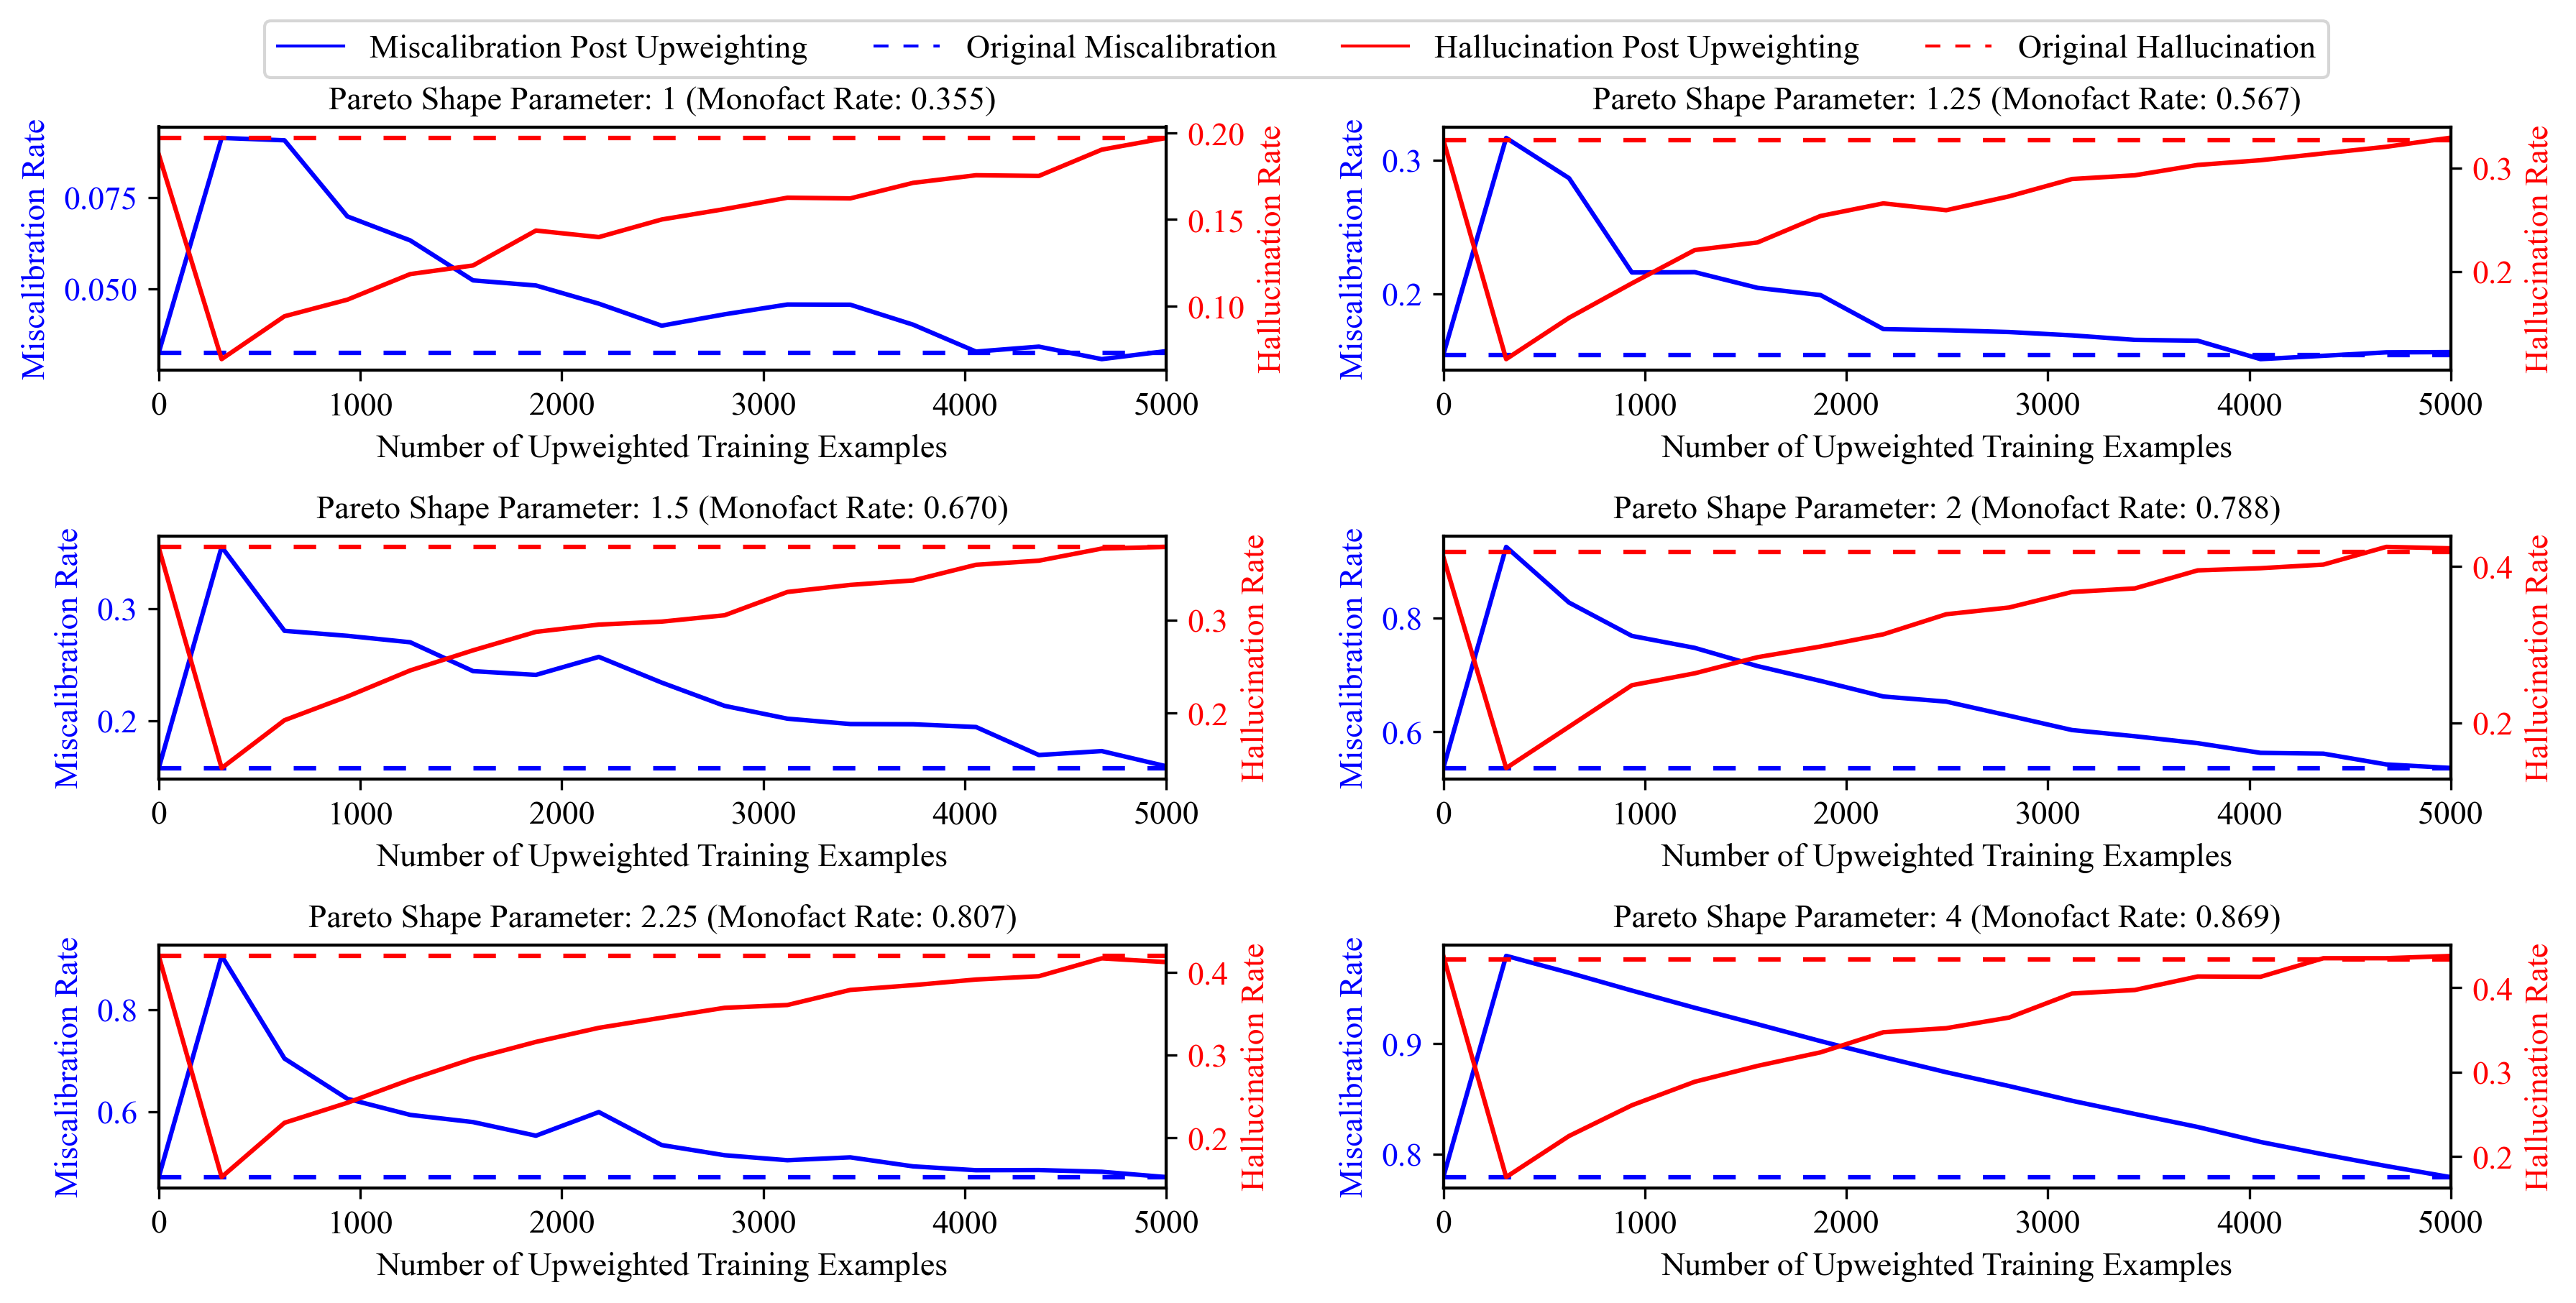

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

# Set font to Times New Roman and increase font size to 11pt for legibility
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'Times New Roman',
    'figure.dpi': 300,  # Higher DPI for better quality
    'lines.linewidth': 1.0,  # Ensure lines are at least 0.5 points thick
    'axes.linewidth': 1.0,  # Make axis lines visible
    'figure.facecolor': 'white',  # Ensure white background
    'axes.facecolor': 'white'
})

def create_icml_figure(results_df, output_path):
    # Create figure and axis objects
    # Adjust figsize as needed to fit ICML guidelines (currently 12x6 inches, with 3x2 subplots)
    fig, axs = plt.subplots(3, 2, figsize=(12, 6))
    axs = axs.ravel()
    
    # Define colors and styles
    primary_color = 'blue'
    secondary_color = 'red'
    pre_linestyle = (0, (5, 5))  # Dashed
    post_linestyle = 'solid'
    
    # Pareto values
    pareto_values = [1, 1.25, 1.5, 2, 2.25, 4]
    
    for idx, pareto_val in enumerate(pareto_values):
        mask = (results_df['Pareto'] == pareto_val)
        pareto_data = results_df[mask].copy()
        
        ax2 = axs[idx].twinx()
        
        # Initialize median_mono as NaN; will update if we have valid data
        median_mono = np.nan
        
        if len(pareto_data) > 0:
            # Sort data by Sample_Changed to ensure proper plotting
            pareto_data = pareto_data.sort_values('Sample_Changed')
            
            # If we have a Mono_Pct column, extract the (unique) monofact rate
            if 'Mono_Pct' in pareto_data.columns:
                # Assuming all rows for this Pareto share the same Mono_Pct
                median_mono = pareto_data['Mono_Pct'].iloc[0]
            
            # Plot Miscalibration
            axs[idx].plot(pareto_data['Sample_Changed'], 
                          pareto_data['Miscalibration_Post'],
                          color=primary_color, linestyle=post_linestyle,
                          label='Post-upweighting', linewidth=1.5)
            
            axs[idx].plot(pareto_data['Sample_Changed'], 
                          pareto_data['Miscalibration_Pre'],
                          color=primary_color, linestyle=pre_linestyle,
                          label='Original', linewidth=1.5)
            
            # Plot Hallucination
            ax2.plot(pareto_data['Sample_Changed'], 
                     pareto_data['Hallucination_Post'],
                     color=secondary_color, linestyle=post_linestyle,
                     label='Post-upweighting', linewidth=1.5)
            
            ax2.plot(pareto_data['Sample_Changed'], 
                     pareto_data['Hallucination_Pre'],
                     color=secondary_color, linestyle=pre_linestyle,
                     label='Original', linewidth=1.5)
            
            # Axes limits and labels
            axs[idx].set_xlim(0, 5000)
            axs[idx].set_xlabel('Number of Upweighted Training Examples')
            axs[idx].set_ylabel('Miscalibration Rate', color=primary_color)
            ax2.set_ylabel('Hallucination Rate', color=secondary_color)
            
            # Ticks
            x_ticks = np.arange(0, 5001, 1000)
            axs[idx].set_xticks(x_ticks)
            axs[idx].tick_params(axis='y', labelcolor=primary_color)
            ax2.tick_params(axis='y', labelcolor=secondary_color)
        
        # Subplot title
        title = f'Pareto Shape Parameter: {pareto_val}'
        if not np.isnan(median_mono):
            title += f' (Monofact Rate: {median_mono:.3f})'
        axs[idx].set_title(title, fontsize=11)
    
    # Create a unified legend for all subplots
    lines = [
        Line2D([0], [0], color=primary_color, linestyle=post_linestyle, 
               label='Miscalibration Post Upweighting'),
        Line2D([0], [0], color=primary_color, linestyle=pre_linestyle, 
               label='Original Miscalibration'),
        Line2D([0], [0], color=secondary_color, linestyle=post_linestyle, 
               label='Hallucination Post Upweighting'),
        Line2D([0], [0], color=secondary_color, linestyle=pre_linestyle, 
               label='Original Hallucination')
    ]
    
    fig.legend(handles=lines, loc='center', bbox_to_anchor=(0.5, 0.98),
               ncol=4, fontsize=11)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the legend
    plt.savefig(output_path, bbox_inches='tight', dpi=600, pad_inches = 0.05)
    plt.show()

# Example usage:
results_df = pd.read_csv("TBU")
results_df = results_df.copy()
results_df['Hallucination_Pre'] = results_df.groupby('Pareto')['Hallucination_Pre'].transform('first')

create_icml_figure(results_df, "TBU")


### Regret Graph

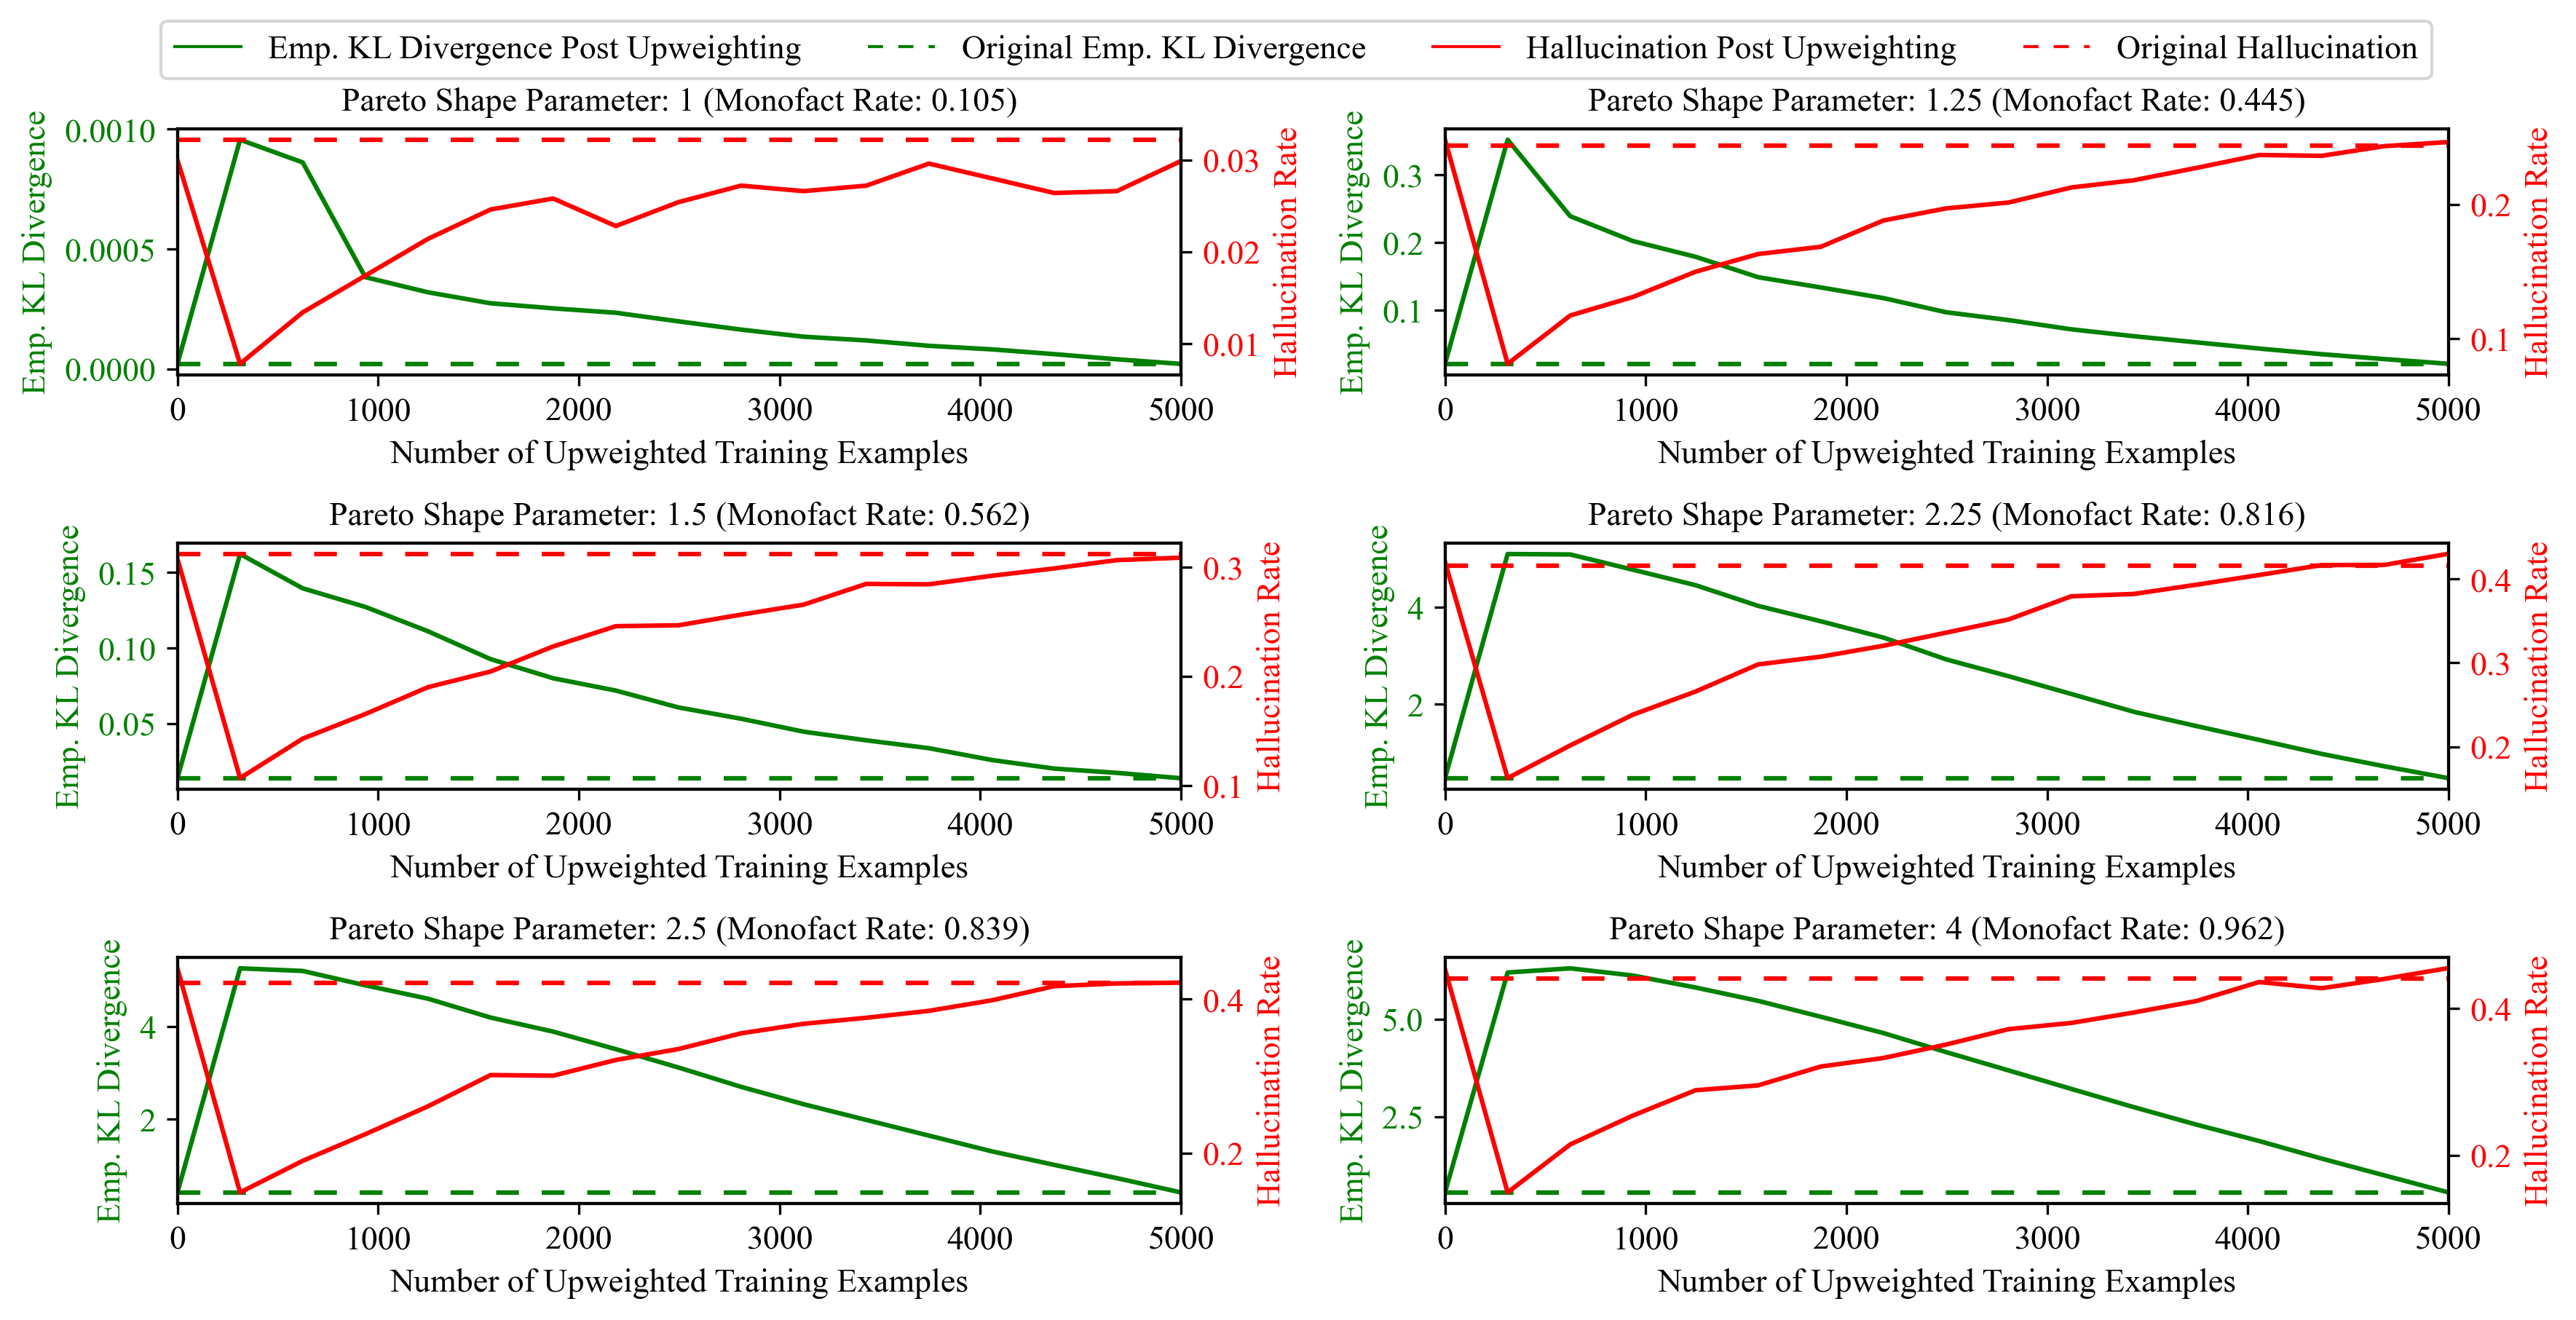

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

# Set font to Times New Roman and increase font size to 11pt for legibility
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'Times New Roman',
    'figure.dpi': 300,  # Higher DPI for better quality
    'lines.linewidth': 1.0,  # Ensure lines are at least 0.5 points thick
    'axes.linewidth': 1.0,  # Make axis lines visible
    'figure.facecolor': 'white',  # Ensure white background
    'axes.facecolor': 'white'
})

def create_icml_figure(results_df, output_path):
    # Create figure and axis objects
    # Adjust figsize as needed to fit ICML guidelines (currently 12x6 inches, with 3x2 subplots)
    fig, axs = plt.subplots(3, 2, figsize=(12, 6))
    axs = axs.ravel()
    
    # Define colors and styles
    primary_color = 'green'
    secondary_color = 'red'
    pre_linestyle = (0, (5, 5))  # Dashed
    post_linestyle = 'solid'
    
    # Pareto values
    pareto_values = [1, 1.25, 1.5, 2.25, 2.5, 4]
    
    for idx, pareto_val in enumerate(pareto_values):
        mask = (results_df['Pareto'] == pareto_val)
        pareto_data = results_df[mask].copy()
        
        ax2 = axs[idx].twinx()
        
        # Initialize median_mono as NaN; will update if we have valid data
        median_mono = np.nan
        
        if len(pareto_data) > 0:
            # Sort data by Sample_Changed to ensure proper plotting
            pareto_data = pareto_data.sort_values('Sample_Changed')
            
            # If we have a Mono_Pct column, extract the (unique) monofact rate
            if 'Mono_Pct' in pareto_data.columns:
                # Assuming all rows for this Pareto share the same Mono_Pct
                median_mono = pareto_data['Mono_Pct'].iloc[0]
            
            # Plot CE Entropy
            axs[idx].plot(pareto_data['Sample_Changed'], 
                          pareto_data['CE_regret_Post'],
                          color=primary_color, linestyle=post_linestyle,
                          label='Post-upweighting', linewidth=1.5)
            
            axs[idx].plot(pareto_data['Sample_Changed'], 
                          pareto_data['CE_regret_Pre'],
                          color=primary_color, linestyle=pre_linestyle,
                          label='Original', linewidth=1.5)
            
            # Plot Hallucination
            ax2.plot(pareto_data['Sample_Changed'], 
                     pareto_data['Hallucination_Post'],
                     color=secondary_color, linestyle=post_linestyle,
                     label='Post-upweighting', linewidth=1.5)
            
            ax2.plot(pareto_data['Sample_Changed'], 
                     pareto_data['Hallucination_Pre'],
                     color=secondary_color, linestyle=pre_linestyle,
                     label='Original', linewidth=1.5)
            
            # Axes limits and labels
            axs[idx].set_xlim(0, 5000)
            axs[idx].set_xlabel('Number of Upweighted Training Examples')
            axs[idx].set_ylabel('Emp. KL Divergence', color=primary_color)
            ax2.set_ylabel('Hallucination Rate', color=secondary_color)
            
            # Ticks
            x_ticks = np.arange(0, 5001, 1000)
            axs[idx].set_xticks(x_ticks)
            axs[idx].tick_params(axis='y', labelcolor=primary_color)
            ax2.tick_params(axis='y', labelcolor=secondary_color)
        
        # Subplot title
        title = f'Pareto Shape Parameter: {pareto_val}'
        if not np.isnan(median_mono):
            title += f' (Monofact Rate: {median_mono:.3f})'
        axs[idx].set_title(title, fontsize=11)
    
    # Create a unified legend for all subplots
    lines = [
        Line2D([0], [0], color=primary_color, linestyle=post_linestyle, 
               label='Emp. KL Divergence Post Upweighting'),
        Line2D([0], [0], color=primary_color, linestyle=pre_linestyle, 
               label='Original Emp. KL Divergence'),
        Line2D([0], [0], color=secondary_color, linestyle=post_linestyle, 
               label='Hallucination Post Upweighting'),
        Line2D([0], [0], color=secondary_color, linestyle=pre_linestyle, 
               label='Original Hallucination')
    ]
    
    fig.legend(handles=lines, loc='center', bbox_to_anchor=(0.5, 0.98),
               ncol=4, fontsize=11)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the legend
    plt.savefig(output_path, dpi=600, bbox_inches='tight', pad_inches=0.05) 
    
    plt.show()

# Example usage:
results_df = pd.read_csv("TBU")
results_df = results_df.copy()
results_df['Hallucination_Pre'] = results_df.groupby('Pareto')['Hallucination_Pre'].transform('first')
create_icml_figure(results_df, "TBU")
